# CPU INFO

In [1]:
!lscpu |grep 'Model name'

Model name:                      AMD Ryzen 7 2700 Eight-Core Processor


# GPU INFO

In [2]:
!nvidia-smi

Thu Apr  8 19:30:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:0A:00.0  On |                  N/A |
| 25%   44C    P0    26W / 120W |    226MiB /  3016MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Matrix multiplication


In [3]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit
from pycuda.tools import make_default_context
import random
random.seed(0)

In [4]:
def genMatrix(n):
    return np.random.uniform(size=(n,n)).astype(np.float32)

# Перемножение матриц на CPU numpy.matmul

In [5]:
def cpuMult(size):
    time_cpu = []
    for n in size:
        matrix = genMatrix(n)
        s = time.time()
        np.matmul(matrix, matrix)
        p = time.time()
        time_cpu.append(p-s)
    return np.array(time_cpu)

# Перемножение матриц на GPU pyCUDA

In [6]:
def gpuPyCuda(n):
    time_pycuda = []
    for n in size:
        matrix = genMatrix(n)
        matrix = gpuarray.to_gpu(matrix) 
        matrix_result = gpuarray.empty((n, n), np.float32)
        mod = compiler.SourceModule("""
__global__ void MatrixMulKernel(float *a, float *b, float *c)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int idy = threadIdx.y + blockIdx.y * blockDim.y;
    float Pvalue = 0;

    for (int k = 0; k < %(MATRIX_SIZE)s; ++k) {
        Pvalue += a[idy * %(MATRIX_SIZE)s + k] * b[k * %(MATRIX_SIZE)s + idx];
    }
    c[idy * %(MATRIX_SIZE)s + idx] = Pvalue;
}
""" % {'MATRIX_SIZE': n} )
        matrixmul = mod.get_function("MatrixMulKernel")
        s = time.time()
        matrixmul(matrix, matrix, matrix_result, block = (32, 32, 1),)
        p = time.time()
        time_pycuda.append(p-s)
    return np.array(time_pycuda)

# Вычисления

In [1]:
startSizeMatrix = 50
size = list(range(50, 3001, 50))

In [2]:
time_cpu = cpuMult(size)

NameError: name 'cpuMult' is not defined

In [3]:
time_cpu

NameError: name 'time_cpu' is not defined

In [10]:
time_pycuda = gpuPyCuda(size)

In [11]:
time_pycuda

array([5.28335571e-04, 3.86238098e-05, 6.34193420e-05, 6.22272491e-05,
       6.36577606e-05, 6.24656677e-05, 6.27040863e-05, 3.81469727e-05,
       4.12464142e-05, 4.43458557e-05, 4.45842743e-05, 4.79221344e-05,
       5.00679016e-05, 5.24520874e-05, 5.43594360e-05, 5.12599945e-05,
       5.19752502e-05, 4.91142273e-05, 5.05447388e-05, 5.00679016e-05,
       5.10215759e-05, 5.00679016e-05, 5.07831573e-05, 5.00679016e-05,
       4.98294830e-05, 5.17368317e-05, 5.22136688e-05, 5.22136688e-05,
       5.17368317e-05, 5.26905060e-05, 5.26905060e-05, 5.38825989e-05,
       5.38825989e-05, 5.45978546e-05, 5.29289246e-05, 5.41210175e-05,
       5.36441803e-05, 5.45978546e-05, 5.41210175e-05, 5.45978546e-05])

# Анализ и визуализация

In [12]:
df = pd.DataFrame({
    'Размер матрицы': size,
    'Время(с)': time_cpu,
    'Тип процессора': len(size)*['CPU']
})
dfg = pd.DataFrame({
    'Размер матрицы': size,
    'Время(с)': time_pycuda,
    'Тип процессора': len(size)*['GPU']
})
ddf = pd.concat([df,dfg])

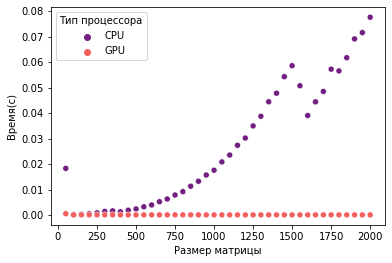

In [14]:
fig, ax = plt.subplots(1,1)
ax = sns.scatterplot(data=ddf, x='Размер матрицы', y='Время(с)', hue='Тип процессора', palette='magma')